In [1]:
import csv
import javalang
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import TfidfVectorizer

# Calcula similitud entre 2
def calculate_similarity(features1, features2):
    # Convert feature dictionaries to vectors
    vector1 = np.array(list(features1.values()))
    vector2 = np.array(list(features2.values()))
    
    # Calculate Euclidean distance
    distance = euclidean(vector1, vector2)
    return distance

# Extrae las features de los AST's
def extract_features(ast):
    features = {}
    # Example feature: number of nodes
    features['num_nodes'] = len(ast['children']) if 'children' in ast else 0
    
    # Example feature: depth of the tree
    features['depth'] = calculate_depth(ast)
    
    return features

def calculate_depth(ast, current_depth=0):
    if not ast['children']:
        return current_depth
    return max(calculate_depth(child, current_depth + 1) for child in ast['children'])

# Generar el AST
def generate_ast(java_code):
    tokens = javalang.tokenizer.tokenize(java_code)
    parser = javalang.parser.Parser(tokens)
    tree = parser.parse()
    return tree

# Normalizar convirtiendolo en Standard Form
def normalize_ast(node):
    if isinstance(node, javalang.ast.Node):
        normalized_node = {
            'type': type(node).__name__,
            'attributes': {},
            'children': []
        }
        for attr, value in node.__dict__.items():
            if isinstance(value, list):
                normalized_node['children'].extend([normalize_ast(child) for child in value if isinstance(child, javalang.ast.Node)])
            elif isinstance(value, javalang.ast.Node):
                normalized_node['children'].append(normalize_ast(value))
            else:
                # Normalize identifiers and literals
                if attr in ('name', 'value'):
                    normalized_node['attributes'][attr] = 'normalized'
                else:
                    normalized_node['attributes'][attr] = value
        return normalized_node
    return str(node)

# AST's a feature vectors
def ast_to_features(code_list):
    # Lista para gurardar los AST's
    normalized_ast_list = []

    # Iterar sobre la lista de codigos
    for code in code_list:
        # Generar el AST
        ast = generate_ast(''.join(code))

        # Normalizar el AST
        normalized_ast = normalize_ast(ast)

        # Convertir el Normalized Ast
        normalized_ast_str = str(normalized_ast)

        # Anadirlo a la lista
        normalized_ast_list.append(normalized_ast_str)

    # Crear el TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Convert the normalized ASTs to feature vectors
    features = vectorizer.fit_transform(normalized_ast_list)

    return features.toarray()

In [2]:
def change_df(df):
    new_df = df.loc[:, ['name_file_1', 'code_java_1', 'name_file_2', 'code_java_2', 'label']]
    
    new_df = new_df.rename(columns={'code_java_1': 'java_code_1', 'code_java_2': 'java_code_2', 'label': 'verdict'})

    return new_df

In [3]:
# Recopila data de los csv
def get_data(no_plagio, plagio, non_plagiarized, plagiarized):
    data1 = pd.read_csv(no_plagio)
    data2 = pd.read_csv(plagio)
    data3 = pd.read_csv(non_plagiarized)
    data4 = pd.read_csv(plagiarized)
    
    conplag = pd.concat([data3, data4], ignore_index=True)
    fire = pd.concat([data1, data2], ignore_index=True)
    conplag = change_df(conplag)

    data = pd.concat([fire, conplag], ignore_index=True)
    return data

In [4]:
def balance_data(df):
    new_df = pd.concat([df[df['verdict'] == 1], df[df['verdict'] == 0].head(400)], ignore_index=True)

    return new_df

In [5]:
data = get_data(
    'codigos_no_plagio.csv',
    'codigos_plagio.csv',
    'non_plagiarized_java_pairs/non_plagiarized_java_pairs.csv',
    'plagiarized_java_pairs.csv'
)

In [6]:
data = balance_data(data)

In [7]:
data = data[['java_code_1', 'java_code_2', 'verdict']]

In [8]:
data

,java_code_1,java_code_2,verdict
0,import java.io.BufferedReader; import java.io....,import java.io.BufferedReader; import java.io....,1
1,import java.util.*; import java.io.*; public c...,import java.util.Arrays; import java.util.Scan...,1
2,import java.math.BigInteger; import java.sql.A...,import java.io.*; import java.util.*; public c...,1
3,import java.math.BigInteger; import java.sql.A...,import java.io.*; import java.util.Arrays; imp...,1
4,import java.math.BigInteger; import java.sql.A...,import java.io.*; import java.util.*; public c...,1
...,...,...,...
730,import java.io.*; import java.util.*; public c...,import java.util.*; import java.io.*; public c...,0
731,import java.io.*; import java.util.*; public c...,import java.util.*; import java.io.*; public c...,0
732,import java.io.*; import java.lang.reflect.Arr...,import java.io.BufferedOutputStream; import ja...,0
733,import java.io.*; import java.lang.reflect.Arr...,import java.util.*; import java.io.*; import j...,0


In [9]:
# Crear listas para ir guardando los AST's
asts_code1 = []
asts_code2 = []
features1 = []
features2 = []
verdicts = []

# Iterar sobre cada row del DataFrame
for index, row in data.iterrows():
    java_code_1 = row['java_code_1']
    java_code_2 = row['java_code_2']
    verdict = row['verdict']
    
    # Generar y Normalizar el AST par los codigos1
    try:
        ast1 = generate_ast(java_code_1)
        normalized_ast1 = normalize_ast(ast1)
        features = extract_features(normalized_ast1)
    except Exception as e:
        normalized_ast1 = str(e)
    asts_code1.append(normalized_ast1)
    features1.append(features)
    
    # Generar y Normalizar el AST par los codigos2
    try:
        ast2 = generate_ast(java_code_2)
        normalized_ast2 = normalize_ast(ast2)
        features = extract_features(normalized_ast2)
    except Exception as e:
        normalized_ast2 = str(e)
    asts_code2.append(normalized_ast2)
    features2.append(features)

    verdicts.append(verdict)

# Crear dataframe con los ast de cada codigo
ast_df = pd.DataFrame({
    'ast_code_1': asts_code1,
    'ast_code_2': asts_code2,
    'verdict': verdicts
})


In [10]:
ast_df

,ast_code_1,ast_code_2,verdict
0,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",1
1,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",1
2,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",1
3,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",1
4,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",1
...,...,...,...
730,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",0
731,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",0
732,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",0
733,"{'type': 'CompilationUnit', 'attributes': {'pa...","{'type': 'CompilationUnit', 'attributes': {'pa...",0


In [11]:
import json

# Función para convertir sets a listas en un diccionario
def convert_sets_to_lists(obj):
    if isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(elem) for elem in obj]
    elif isinstance(obj, set):
        return list(obj)
    else:
        return obj

# Aplicar la función a los ASTs
ast_df['ast_code_1_clean'] = ast_df['ast_code_1'].apply(convert_sets_to_lists)
ast_df['ast_code_2_clean'] = ast_df['ast_code_2'].apply(convert_sets_to_lists)

# Convertir los ASTs a cadenas JSON
ast_df['ast_code_1_str'] = ast_df['ast_code_1_clean'].apply(json.dumps)
ast_df['ast_code_2_str'] = ast_df['ast_code_2_clean'].apply(json.dumps)

# Combinar los dos códigos AST en una sola cadena por cada fila
ast_df['combined_ast_code'] = ast_df['ast_code_1_str'] + " " + ast_df['ast_code_2_str']

# Separar las características y las etiquetas
X = ast_df['combined_ast_code']
y = ast_df['verdict']

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Convert the normalized ASTs to feature vectors
features = vectorizer.fit_transform(X)

In [13]:
features

<735x9351 sparse matrix of type '<class 'numpy.float64'>'
	with 256785 stored elements in Compressed Sparse Row format>

In [14]:
feature_names = vectorizer.get_feature_names_out()
tfidf_array = features.toarray()

# Crear un DataFrame con las características y sus valores TF-IDF
df_tfidf = pd.DataFrame(tfidf_array, columns=feature_names)

In [15]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()

In [16]:
from sklearn.model_selection import train_test_split
# Separar los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

In [17]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
# Predicciones con XGBoost
y_pred = xgb_classifier.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
cr = classification_report(y_test, y_pred)
print('Classification Report:\n', cr)

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80        75
           1       0.84      0.67      0.74        72

    accuracy                           0.78       147
   macro avg       0.79      0.77      0.77       147
weighted avg       0.79      0.78      0.77       147



Confusion Matrix:
 [[66  9]
 [24 48]]


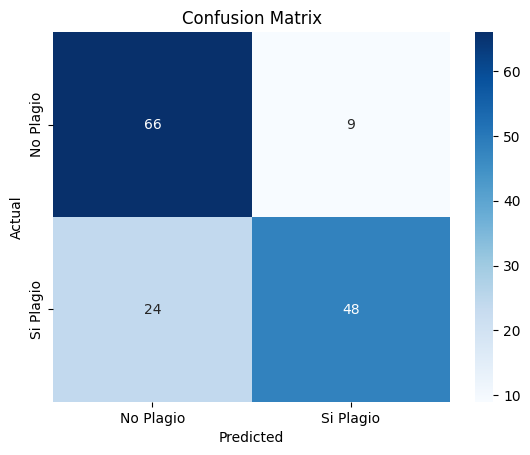

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

labels = ['No Plagio', 'Si Plagio'] 

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Añadir titulo y labels de los ejes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)

# Mostrar la matriz de confusion
plt.show()